# Part III: Build Transformer with PyTorch [25 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

### **Dataset Chosen:**  `ag_news_csv`

2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

In [61]:
#Import necessary libraries

import pandas as pd
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
%matplotlib inline

In [2]:
#Run if you don't have it in local
#nltk.download('stopwords')
#nltk.download('punkt_tab')

In [3]:
df = pd.read_csv("ag_news_csv/train.csv", header=None ,names=["Class", "Title", "Description"])
df

,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [4]:
#Defining few helper functions

def exp_data(df: pd.DataFrame):

    class_labels = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

    print("Dataset Information:")
    df.info()
    print("\n")

    print("Dataset Shape (rows, columns):", df.shape, "\n")

    print("Missing Values (per column):")
    print(df.isnull().sum(), "\n")

    print("Class Distribution:")
    class_counts = df['Class'].value_counts().sort_index()
    for class_num, count in class_counts.items():
        label = class_labels.get(class_num, f"Unknown Class ({class_num})")
        per = (count / len(df)) * 100
        print(f" - {label} ({class_num}): {count} entries ({per:.2f}%)")
    print("\n")

    print("Basic Statistics for Text Columns:")
    for col in ['Title', 'Description']:
        print(f"\n Column: {col}")
        text_len = df[col].astype(str).apply(lambda x: len(x.split()))
        print(f" - Average word count: {text_len.mean():.2f}")
        print(f" - Median word count: {text_len.median():.2f}")
        print(f" - Min words: {text_len.min()}, Max words: {text_len.max()}")


def polarity_dist(df: pd.DataFrame, text_column: str):

    polarities = []
    for text in df[text_column].astype(str):
        polarity = TextBlob(text).sentiment.polarity
        polarities.append(polarity)

    plt.figure()
    plt.hist(polarities, bins=30)
    plt.title(f"Polarity Distribution for '{text_column}'")
    plt.xlabel("Polarity")
    plt.ylabel("Frequency")
    plt.show()

def word_count_dist(df: pd.DataFrame, text_column: str):

    word_counts = []
    for text in df[text_column].astype(str):
        tokens = nltk.word_tokenize(text)
        word_counts.append(len(tokens))

    plt.figure()
    plt.hist(word_counts, bins=30)
    plt.title(f"Word Count Distribution for '{text_column}'")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()

def top_n_words(df: pd.DataFrame, text_column: str, n: int = 20, alpha: bool = False):

    corpus = " ".join(df[text_column].astype(str)).lower()
    tokens = nltk.word_tokenize(corpus)

    if alpha:
        tokens = [token for token in tokens if token.isalpha()]

    freq_dist = nltk.FreqDist(tokens)
    most_common = freq_dist.most_common(n)

    words, counts = zip(*most_common)

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='cornflowerblue' if alpha else 'salmon')
    alpha_status = 'Alphabetic Only' if alpha else 'All Tokens (Mixed Characters Included)'
    plt.title(f"Top {n} Most Frequent Words ({alpha_status}) in '{text_column}'")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [5]:
exp_data(df)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Dataset Shape (rows, columns): (120000, 3) 

Missing Values (per column):
Class          0
Title          0
Description    0
dtype: int64 

Class Distribution:
 - World (1): 30000 entries (25.00%)
 - Sports (2): 30000 entries (25.00%)
 - Business (3): 30000 entries (25.00%)
 - Sci/Tech (4): 30000 entries (25.00%)


Basic Statistics for Text Columns:

 Column: Title
 - Average word count: 6.78
 - Median word count: 7.00
 - Min words: 1, Max words: 19

 Column: Description
 - Average word count: 31.06
 - Median word count: 30.00
 - Min words: 3, Max words: 173


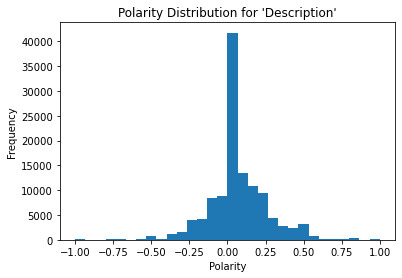

In [7]:
polarity_dist(df,'Description')

The above plot explains on how the polarity of the description column is distributed accross. Majority of the news is focused to be neutral in nature but few are spread to be positive and negative in few other cases.

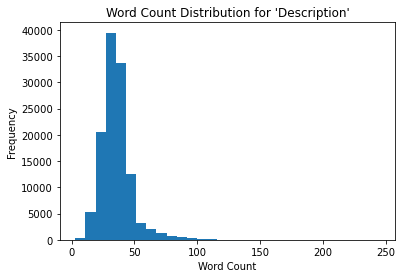

In [8]:
word_count_dist(df,'Description')

The number of words in the description column is focused to be around 46-48 words on average but there are few outliers towards 100 and near 0 which we address using padding and clipping few words.

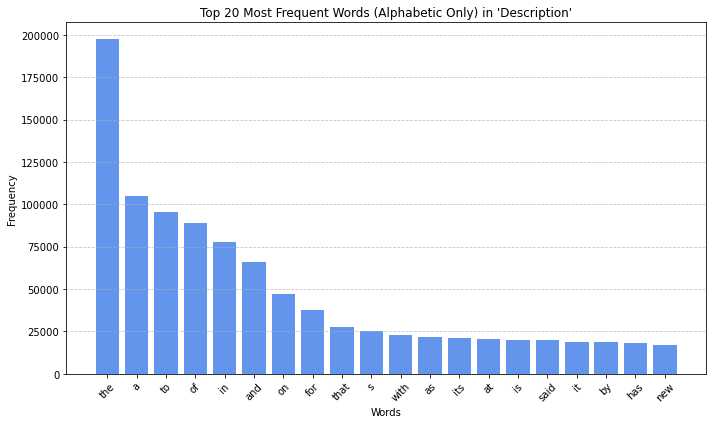

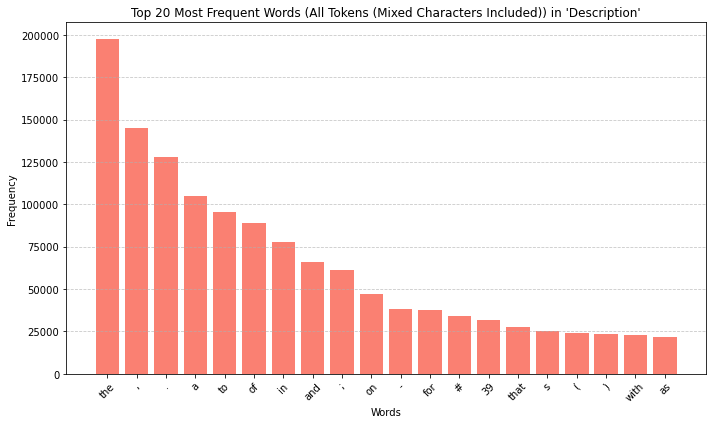

In [9]:
top_n_words(df,'Description', n=20, alpha=True)
top_n_words(df,'Description', n=20, alpha=False)

The above plots help understand which words or characters appear the most in the whole set of descriptions. This hugely helps in the data cleaning part as we remove stop words and clean unrecognised characters or punctuations or noise from the data for faster training and efficiency. 

In [10]:
#Description column analysis for data cleaning 
patterns = {
    'Dollar ($)': r'\$',
    'Multipe Period (..)': r'\.\.',
    's': r'\s+s\s+',
    'Semicolon (;)': r';',
    'Hyphen (-)': r'-',
    'Multiple Slashes (\\)': r'\\\\',
    'Newline (/n)': r'\s+/n\s+',
    'Word quot;': r'quot;',
    'Brackets ()': r'\(\)'
}

for description, pattern in patterns.items():
    print(f"\n{'='*15} Examples containing {description} {'='*15}\n")
    
    matching = df[df['Description'].astype(str).str.contains(pattern, regex=True, case=False, na=False)]

    if matching.empty:
        print("No matches found for this pattern.\n")
        continue
    
    for idx, desc in matching.head(2)['Description'].items():
        matches_found = re.findall(pattern, str(desc), flags=re.IGNORECASE)
        print(f"Index {idx}:\n{desc}\n")
        print(f"Matches found: {matches_found}\n{'-'*60}\n")


=============== Examples containing Dollar ($) ===============

Index 18:
The US trade deficit has exploded 19 to a record \$55.8bn as oil costs drove imports higher, according to a latest figures.

Matches found: ['$']
------------------------------------------------------------

Index 26:
An auction of shares in Google, the web search engine which could be floated for as much as \$36bn, takes place on Friday.

Matches found: ['$']
------------------------------------------------------------


=============== Examples containing Multipe Period (..) ===============

Index 40:
Target the abusers of legal weapons We can all share the outrage, expressed by columnist Steve Bailey (''Summer Sizzler, quot; Aug. 11), at the killings in the city's poor neighborhoods. But there's no need to share his ignorance. He argues for renewal of the so-called assault weapon ban, claiming that otherwise, ''UZIs and AK-47s could again be flooding the streets. quot; His ...

Matches found: ['..']
---------

In [11]:
#Title column analysis for data cleaning 
patterns = {
    'Dollar ($)': r'\$',
    'Multipe Period (..)': r'\.\.',
    '(s)': r'\s+s\s+',
    'Semicolon (;)': r';',
    'Hyphen (-)': r'-',
    'Multiple Slashes (\\)': r'\\\\',
    'Newline (/n)': r'\s+/n\s+',
    'Word quot;': r'quot;',
    'Semicolon': r';'
}

for description, pattern in patterns.items():
    print(f"\n{'='*15} Examples containing {description} {'='*15}\n")
    
    matching = df[df['Title'].astype(str).str.contains(pattern, regex=True, case=False, na=False)]

    if matching.empty:
        print("No matches found for this pattern.\n")
        continue
    
    for idx, desc in matching.head(2)['Title'].items():
        matches_found = re.findall(pattern, str(desc), flags=re.IGNORECASE)
        print(f"Index {idx}:\n{desc}\n")
        print(f"Matches found: {matches_found}\n{'-'*60}\n")


=============== Examples containing Dollar ($) ===============

Index 33:
Saudi phone sector gets \$1bn lift

Matches found: ['$']
------------------------------------------------------------

Index 44:
State grant to aid Lynn; Bank gives Salem \$10k

Matches found: ['$']
------------------------------------------------------------


=============== Examples containing Multipe Period (..) ===============

Index 53:
What's Cool In the Pool ... ... And Hot On the Deck

Matches found: ['..', '..']
------------------------------------------------------------

Index 167:
RuntimeProperties... Reflection from System Properties

Matches found: ['..']
------------------------------------------------------------


=============== Examples containing (s) ===============

Index 580:
Iraq troops move angers S Koreans

Matches found: [' S ']
------------------------------------------------------------

Index 8120:
The Investment Column: Chief goes but S amp;F remains a buy

Matches found: [' S ']
-

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [12]:
#To clean the text data based on the above analysis
def clean_t(text: str, title: bool = False) -> str:

    text = text.lower()
    text = re.sub(r'\\\$', r'$', text) #Replaces occurrences of "\$" with "$"

    text = re.sub(r'\.{2,}', '', text)  #Removes multiple consecutive periods 
    
    text = re.sub(r"''", '', text)     #Removes empty quotes ('') with nothing inside
    
    if title: 
        text = re.sub(r'\s*#\d+;', '', text)   #Removes numbered hashtags patterns like "#36;"
    else: 
        text = re.sub(r'\s*#\d+;', ' ', text)  

    text = re.sub(r'(?<=[a-zA-Z])\\(?=[a-zA-Z])', '', text)  #Removes single backslash between alphabets

    text = re.sub(r'quot;', '', text)     #Removes occurrences of "quot;"
    
    text = re.sub(r'\(\s*\)', '', text)   #Removes brackets () containing nothing inside 
    text = re.sub(r'[()]', '', text)
    
    text = re.sub(r'\s*amp;', ' ', text)  #Removes 'amp;' 
    text = re.sub(r'\s\\+\s', ' ', text)  #Removes multiple backslashes "\\" or more
    text = re.sub(r'\\{2,}', ' ', text)  
    
    text = re.sub(r"(\b\w+)'s\b", r"\1", text) #Makes plural forms to singular
    
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def tokenize(text: str, stop_words: bool = True) -> list:

    tokens = word_tokenize(text)
    
    if stop_words:
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

def preprocess_t(df: pd.DataFrame, text_column: str, stop_words: bool = True, title: bool = False) -> pd.DataFrame:

    processed_texts = []
    for text in df[text_column].astype(str):
        clean = clean_t(text, title)
        tokens = tokenize(clean, stop_words)
        processed_texts.append(tokens)
    
    new_col_name = text_column + "_processed"
    df[new_col_name] = processed_texts
    return df

In [13]:
#Preprocess the text data and tokenize
df = preprocess_t(df, text_column='Description', stop_words=True)
df = preprocess_t(df, text_column='Title', stop_words=True, title=True)

In [14]:
df

,Class,Title,Description,Description_processed,Title_processed
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...","[reuters, -, short-sellers, ,, wall, street, d...","[wall, st., bears, claw, back, black, reuters]"
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,"[reuters, -, private, investment, firm, carlyl...","[carlyle, looks, toward, commercial, aerospace..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,"[reuters, -, soaring, crude, prices, plus, wor...","[oil, economy, cloud, stocks, ', outlook, reut..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,"[reuters, -, authorities, halted, oil, exportf...","[iraq, halts, oil, exports, main, southern, pi..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","[afp, -, tearaway, world, oil, prices, ,, topp...","[oil, prices, soar, all-time, record, ,, posin..."
...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,"[karachi, reuters, -, pakistani, president, pe...","[pakistan, musharraf, says, wo, n't, quit, arm..."
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,"[red, sox, general, manager, theo, epstein, ac...","[renteria, signing, top-shelf, deal]"
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,"[miami, dolphins, put, courtship, lsu, coach, ...","[saban, going, dolphins, yet]"
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,"[pittsburgh, ny, giants, time, :, 1:30, p.m., ...","[today, nfl, games]"


In [15]:
def max_perc(tokenized_texts, percentile=98):
    lengths = [len(tokens) for tokens in tokenized_texts]
    return int(np.percentile(lengths, percentile))

combined_tokens = [t + d for t, d in zip(df['Title_processed'], df['Description_processed'])]

max_len_comb = max_perc(combined_tokens, percentile=98)
print(f"Combined max_len (98th percentile): {max_len_comb}")

Combined max_len (98th percentile): 57


In [16]:
#Train the word2vec embeddings on the data 
w2v = Word2Vec(
    sentences=combined_tokens,
    vector_size=128,
    window=5,
    min_count=2,
    workers=8,
    epochs=15
)

In [17]:
vocab = list(w2v.wv.index_to_key)
vocab_dict = {word: idx+2 for idx, word in enumerate(vocab)}  # PAD=0, UNK=1

embedding_matrix = np.zeros((len(vocab_dict) + 2, 128))
for word, idx in vocab_dict.items():
    embedding_matrix[idx] = w2v.wv[word]

In [18]:
class News_Data(Dataset):
    def __init__(self, tokenized_titles, tokenized_descs, labels, vocab_dict, max_len):
        self.tokenized_titles = tokenized_titles
        self.tokenized_descs = tokenized_descs
        self.labels = labels
        self.vocab_dict = vocab_dict
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def encode(self, tokens):
        encoded = [self.vocab_dict.get(token, 1) for token in tokens]  #UNK 1
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len]
        else:
            encoded += [0] * (self.max_len - len(encoded))  #PAD 0
        return torch.tensor(encoded, dtype=torch.long)  

    def __getitem__(self, idx):
        combined_tokens = self.tokenized_titles[idx] + self.tokenized_descs[idx]
        return self.encode(combined_tokens), torch.tensor(self.labels[idx]-1, dtype=torch.long)

## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

In [19]:
class Transformer(nn.Module):
    def __init__(self, embedding_matrix, num_classes, num_heads, num_layers, max_len, dropout=0.2):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=False,
            padding_idx=0
        )
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x) + self.pos_encoder[:, :x.size(1), :]
        encoded = self.transformer_encoder(embedded)
        pooled = encoded.mean(dim=1)
        out = self.dropout(pooled)
        return self.fc_out(out)

3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Transformer(
    embedding_matrix=embedding_matrix,
    num_classes=4,
    num_heads=4,
    num_layers=2,
    max_len=max_len_comb,
    dropout=0
).to(device)

4.	Print model summary using torchinfo.summary

In [21]:
batch_size = 64
dummy_input = torch.randint(0, len(vocab_dict)+2, (batch_size, max_len_comb)).to(device).long()
summary(model, input_data=dummy_input)

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [64, 4]                   7,296
├─Embedding: 1-1                              [64, 57, 128]             7,016,960
├─TransformerEncoder: 1-2                     [64, 57, 128]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 57, 128]             593,024
│    │    └─TransformerEncoderLayer: 3-2      [64, 57, 128]             593,024
├─Dropout: 1-3                                [64, 128]                 --
├─Linear: 1-4                                 [64, 4]                   516
Total params: 8,210,820
Trainable params: 8,210,820
Non-trainable params: 0
Total mult-adds (M): 449.12
Input size (MB): 0.03
Forward/backward pass size (MB): 3.74
Params size (MB): 28.07
Estimated Total Size (MB): 31.84

5. Briefly describe the Transformer architecture you have defined.

The model is a Transformer design specifically tailored for text classification into four news categories. It begins with an Embedding Layer, which maps input tokens to 128-dimensional dense vectors leveraging pre-trained Word2Vec embeddings where robust semantic meanings are preserved. Positional encoding is implicitly added to preserve word order within sequences. The embeddings pass through two Transformer Encoder Layers with multi-head self-attention (4 heads) and feed-forward networks so the model is able to learn word interdependencies and stabilize training with dropout and layer normalization. 

After encoding, representations of the sequence are mean-pooled into a single fixed-length vector and dropout applied afterwards for overfitting prevention. There is a final Classification Layer projecting this representation to logits for the four classes. The architecture has 8.2 million parameters, with most being contributed by the embedding layer (7 million). Although it is complex, it is computationally efficient, requiring around 449 million operations at inference time, and therefore is extremely well-suited to semantic understanding and sequence modeling tasks in text classification.

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [22]:
train_dataset = News_Data(
    df['Title_processed'],
    df['Description_processed'],
    df['Class'],
    vocab_dict,
    max_len_comb
)

train_ratio = 0.9
val_ratio = 0.1

train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

batch_size = 64

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [23]:
def train_m(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss, correct_train = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / len(train_loader.dataset)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct_val = 0.0, 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                predictions = val_outputs.argmax(dim=1)
                correct_val += (predictions == val_labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / len(val_loader.dataset)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f}")

    epochs = range(1, num_epochs + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(epochs, train_losses, marker='o', label='Train Loss')
    axs[0].plot(epochs, val_losses, marker='o', label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train & Validation Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, train_accuracies, marker='o', label='Train Accuracy')
    axs[1].plot(epochs, val_accuracies, marker='o', label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train & Validation Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

Epoch [1/10] | Train Loss: 0.3110 | Train Acc: 0.8943 | Val Loss: 0.2526 | Val Acc: 0.9137
Epoch [2/10] | Train Loss: 0.2394 | Train Acc: 0.9170 | Val Loss: 0.2311 | Val Acc: 0.9206
Epoch [3/10] | Train Loss: 0.2009 | Train Acc: 0.9298 | Val Loss: 0.2232 | Val Acc: 0.9232
Epoch [4/10] | Train Loss: 0.1679 | Train Acc: 0.9415 | Val Loss: 0.2212 | Val Acc: 0.9233
Epoch [5/10] | Train Loss: 0.1371 | Train Acc: 0.9525 | Val Loss: 0.2318 | Val Acc: 0.9247
Epoch [6/10] | Train Loss: 0.1096 | Train Acc: 0.9626 | Val Loss: 0.2523 | Val Acc: 0.9225
Epoch [7/10] | Train Loss: 0.0879 | Train Acc: 0.9701 | Val Loss: 0.2709 | Val Acc: 0.9203
Epoch [8/10] | Train Loss: 0.0705 | Train Acc: 0.9764 | Val Loss: 0.3088 | Val Acc: 0.9148
Epoch [9/10] | Train Loss: 0.0568 | Train Acc: 0.9811 | Val Loss: 0.3381 | Val Acc: 0.9115
Epoch [10/10] | Train Loss: 0.0454 | Train Acc: 0.9845 | Val Loss: 0.3702 | Val Acc: 0.9170


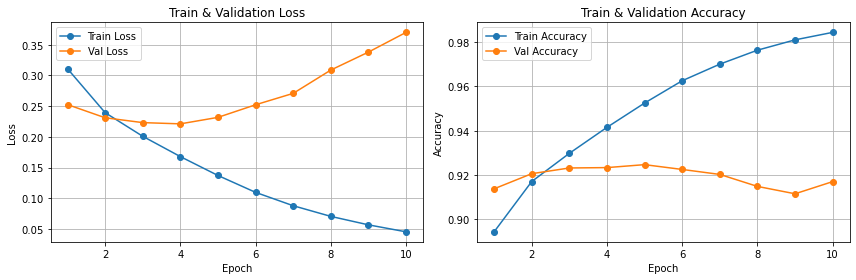

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epoch = 10

train_m(model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epoch
)

The above plots clearly shows overfitting of the base model as the train accuracies and losses totally diverge from the validation accuracies and losses. This helps us to introduce regularizations and optimizations in the model to improve it's performance and help the model learn better.

## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [55]:
#Defining helper functions for better optimization techniques
class EarlyStopping:

    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def val_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    device,
    num_epochs=20,
    lr=1e-3,
    weight_decay=1e-5,  
    patience=3,         
    save_path="best_model.pt"):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=patience, delta=0.0)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)

        val_loss, val_acc = val_one_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

    return train_losses, val_losses, train_accs, val_accs

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    axes[0].plot(epochs, val_losses, label='Val Loss', marker='x')
    axes[0].set_title('Training & Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(epochs, train_accs, label='Train Accuracy', marker='o')
    axes[1].plot(epochs, val_accs, label='Val Accuracy', marker='x')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def load_best_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()

def evaluate_test_with_probs(model, dataloader, criterion, device):

    model.eval()
    test_loss = 0.0
    correct = 0
    all_labels = []
    all_probs = [] 

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
    
    all_probs = np.concatenate(all_probs, axis=0)
    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, np.array(all_labels), all_probs

def compute_metrics(labels, preds, average='macro'):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=average)
    return precision, recall, f1

def plot_multiclass_roc(all_labels, all_probs, n_classes=4):

    y_true = label_binarize(all_labels, classes=list(range(n_classes)))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multi-class ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.show()

In [47]:
criterion = nn.CrossEntropyLoss()

model = Transformer(
    embedding_matrix=embedding_matrix,
    num_classes=4,
    num_heads=4,
    num_layers=2,
    max_len=max_len_comb,
    dropout=0.4
    ).to(device)

In [48]:
train_losses, val_losses, train_accs, val_accs = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        device=device,
        num_epochs=30,       
        lr=1e-5,             
        weight_decay=1e-5,   
        patience=2,          
        save_path="best_model.pt"
    )

Epoch [1/30] Train Loss: 0.4934 | Train Acc: 0.8413 | Val Loss: 0.3360 | Val Acc: 0.8916
Epoch [2/30] Train Loss: 0.3368 | Train Acc: 0.8877 | Val Loss: 0.3201 | Val Acc: 0.8968
Epoch [3/30] Train Loss: 0.3176 | Train Acc: 0.8943 | Val Loss: 0.3124 | Val Acc: 0.8996
Epoch [4/30] Train Loss: 0.3075 | Train Acc: 0.8979 | Val Loss: 0.3011 | Val Acc: 0.9038
Epoch [5/30] Train Loss: 0.2995 | Train Acc: 0.8999 | Val Loss: 0.3010 | Val Acc: 0.9032
Epoch [6/30] Train Loss: 0.2917 | Train Acc: 0.9017 | Val Loss: 0.2945 | Val Acc: 0.9068
Epoch [7/30] Train Loss: 0.2854 | Train Acc: 0.9034 | Val Loss: 0.2853 | Val Acc: 0.9086
Epoch [8/30] Train Loss: 0.2783 | Train Acc: 0.9061 | Val Loss: 0.2779 | Val Acc: 0.9105
Epoch [9/30] Train Loss: 0.2718 | Train Acc: 0.9080 | Val Loss: 0.2749 | Val Acc: 0.9111
Epoch [10/30] Train Loss: 0.2656 | Train Acc: 0.9097 | Val Loss: 0.2774 | Val Acc: 0.9084
Epoch [11/30] Train Loss: 0.2607 | Train Acc: 0.9121 | Val Loss: 0.2659 | Val Acc: 0.9120
Epoch [12/30] Train

In [50]:
df_test = pd.read_csv("ag_news_csv/test.csv", header=None ,names=["Class", "Title", "Description"])
df_test = preprocess_t(df_test, text_column='Description', stop_words=True)
df_test = preprocess_t(df_test, text_column='Title', stop_words=True, title=True)

test_dataset = News_Data(
    df_test['Title_processed'],
    df_test['Description_processed'],
    df_test['Class'],
    vocab_dict,
    max_len_comb
)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [56]:
test_loss, test_accuracy, all_labels, all_probs  = evaluate_test_with_probs(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.2724, Test Accuracy: 0.9114


2. Discuss how the optimization techniques helped to improve the performance of the model.

Observing the training epochs from the improved model which contains optimizations such as dropouts, weight decay and early stopping which hugely contribute in avoiding the overfitting of the model thus converging the train and validation accuracies and losses perfectly. We visualize the plots below which clearly depicts on how well the model performed compared to our base model.

**Dropout:**  By randomly zeroing out a subset of neuron activations during training, dropout forced the model to learn more robust representations that don’t rely on a few dominant features. This reduced overfitting and improved generalization on unseen data.

**Weight decay:** L2 regularization penalized large weights by adding a penalty term to the loss function, which encouraged the model to distribute importance across many features rather than over-relying on a few. This simplicity helped reduce variance and overfitting, leading to more stable and generalizable performance.

**Early Stopping:** Early stopping monitored validation loss and halts training when the model stops improving. This prevented the model from training too long on the training data, reducing the risk of overfitting and ensuring that the saved model corresponds to the best generalization performance.

Together, these techniques helped strike a balance between model complexity and generalization, resulting in improved performance on both validation and test sets.

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [57]:
load_best_model(model, "best_model.pt", device)

4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

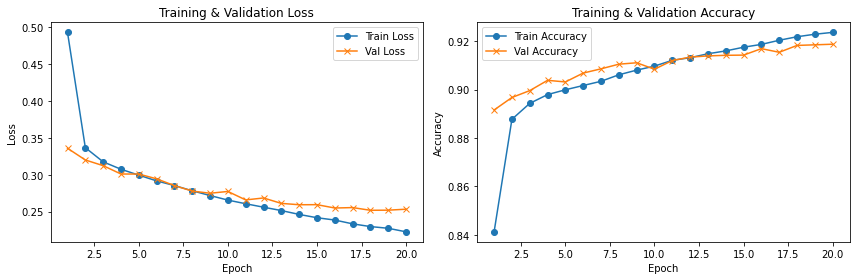

In [58]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

From the above plots, training loss decreases gradually with epochs, suggesting good learning. Validation loss decreases as well, which means that the model is generalizing pretty well. While training accuracy is increasing steadily towards a high point, validation accuracy also rises similarly but slightly less—this slim difference suggests some overfitting but not excess. Generally, the model shows improved performance on both training and validation sets, suggesting decent generalization.

   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


   e. Plot the ROC curve.

In [59]:
precision, recall, f1 = compute_metrics(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Precision: 0.9120, Recall: 0.9114, F1: 0.9113


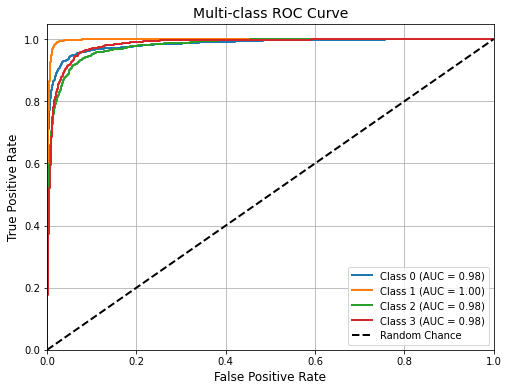

In [62]:
plot_multiclass_roc(all_labels, all_probs, n_classes=4)

   f. [Optional] Use TensorBoard (or a similar tool, e.g. Wandb) to log the training and validation loss and accuracy over epochs, generate the charts, and attach the SVG images of the charts.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

**References:**

- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). *Attention is All You Need.* Advances in Neural Information Processing Systems (NeurIPS). [Link](https://arxiv.org/abs/1706.03762)

- Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.* arXiv preprint arXiv:1810.04805. [Link](https://arxiv.org/abs/1810.04805)

-  Prechelt, L. (1998). *Early Stopping - But When?* In Neural Networks: Tricks of the Trade (pp. 55-69). Springer. [Link](https://link.springer.com/chapter/10.1007/3-540-49430-8_3)

- Ng, A. (2004). *Feature Selection, L1 vs. L2 Regularization, and Rotational Invariance.* In Proceedings of the Twenty-first International Conference on Machine Learning (ICML '04). [Link](http://www.cs.cmu.edu/~aaba/10701_sp09/lectures/regularization.pdf)

- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning.* Springer. [Link](https://www.springer.com/gp/book/9780387310732)

- Dataset: [Link](https://drive.google.com/drive/u/0/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M?resourcekey=0-TLwzfR2O-D2aPitmn5o9VQ)


6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
| Shreyas Bellary Manjunath  | 1,2,3,4 | 50  |
| Ruthvik Vasantha Kumar  | 1,2,3,4  | 50 |
|   | **Total** | 100  |